In [4]:
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

In [1]:
import torchvision
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torchvision.transforms.functional as Tf


ycb = [
    "003_cracker_box.sdf", "004_sugar_box.sdf", "005_tomato_soup_can.sdf",
    "006_mustard_bottle.sdf", "009_gelatin_box.sdf", "010_potted_meat_can.sdf"
]

def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

num_classes = len(ycb)+1
model = get_instance_segmentation_model(num_classes)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device(
    'cpu')
model.load_state_dict(
    torch.load('clutter_maskrcnn_model.pt', map_location=device))
model.eval()

model.to(device)
print('model loaded')

NameError: name 'torch' is not defined

In [3]:
import cv2
import numpy as np
import random
import torch

COLORS = np.random.uniform(0, 255, size=(len(ycb), 3))

def get_outputs(image, model, threshold):
    with torch.no_grad():
        # forward pass of the image through the modle
        outputs = model(image)
    
    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    # get the masks
    masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # discard masks for objects which are below threshold
    masks = masks[:thresholded_preds_count]
    # get the bounding boxes, in (x1, y1), (x2, y2) format
    boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
    # discard bounding boxes below threshold value
    boxes = boxes[:thresholded_preds_count]
    # get the classes labels
    labels = [ycb[i] for i in outputs[0]['labels']]
    return masks, boxes, labels

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1 
    beta = 0.6 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    for i in range(len(masks)):
        red_map = np.zeros_like(masks[i]).astype(np.uint8)
        green_map = np.zeros_like(masks[i]).astype(np.uint8)
        blue_map = np.zeros_like(masks[i]).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = color
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        #convert the original PIL image into NumPy format
        image = np.array(image)
        # convert from RGN to OpenCV BGR format
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # apply mask on the image
        #cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
        # draw the bounding boxes around the objects
        cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color, 
                      thickness=2)
        # put the label text above the objects
        cv2.putText(image , labels[i], (boxes[i][0][0], boxes[i][0][1]-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 
                    thickness=2, lineType=cv2.LINE_AA)
    
    return image

(903, 305)
torch.Size([3, 305, 903])
torch.Size([1, 3, 305, 903])


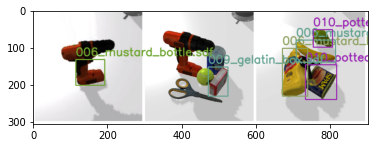

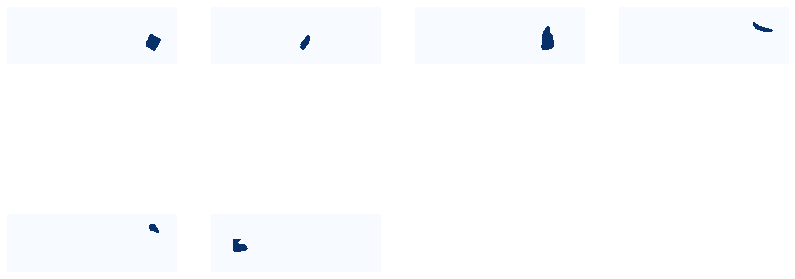

In [26]:
import torch
import torchvision
import cv2
from PIL import Image
from torchvision.transforms import transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor()
    ])


image = Image.open("scenarios2.png").convert('RGB')
# keep a copy of the original image for OpenCV functions and applying masks
orig_image = image.copy()
# transform the image
print(image.size)
image = transform(image)
print(image.shape)
# add a batch dimension
image = image.unsqueeze(0).to(device)
print(image.shape)
masks, boxes, labels = get_outputs(image, model, 0.99)
result = draw_segmentation_map(orig_image, masks, boxes, labels)
# visualize the image
plt.imshow(result)
plt.show()

display_images(masks * 255, cmap="Blues", interpolation="none")

In [28]:
masks[0].shape

(305, 903)

In [32]:
masks[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [22]:
masks[1]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
labels

['010_potted_meat_can.sdf',
 '009_gelatin_box.sdf',
 '006_mustard_bottle.sdf',
 '006_mustard_bottle.sdf',
 '010_potted_meat_can.sdf',
 '006_mustard_bottle.sdf',
 '006_mustard_bottle.sdf',
 '006_mustard_bottle.sdf',
 '004_sugar_box.sdf',
 '010_potted_meat_can.sdf',
 '009_gelatin_box.sdf',
 '006_mustard_bottle.sdf',
 '004_sugar_box.sdf',
 '006_mustard_bottle.sdf',
 '010_potted_meat_can.sdf',
 '006_mustard_bottle.sdf',
 '010_potted_meat_can.sdf',
 '009_gelatin_box.sdf',
 '006_mustard_bottle.sdf',
 '009_gelatin_box.sdf',
 '004_sugar_box.sdf',
 '009_gelatin_box.sdf',
 '010_potted_meat_can.sdf',
 '006_mustard_bottle.sdf',
 '004_sugar_box.sdf',
 '009_gelatin_box.sdf',
 '004_sugar_box.sdf',
 '005_tomato_soup_can.sdf',
 '004_sugar_box.sdf',
 '009_gelatin_box.sdf',
 '004_sugar_box.sdf',
 '009_gelatin_box.sdf',
 '006_mustard_bottle.sdf',
 '006_mustard_bottle.sdf']

In [5]:
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [6]:
import cv2
import numpy as np
import random
import torch

COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

def get_outputs(image, model, threshold):
    with torch.no_grad():
        # forward pass of the image through the modle
        outputs = model(image)
    
    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    # get the masks
    masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # discard masks for objects which are below threshold
    masks = masks[:thresholded_preds_count]
    # get the bounding boxes, in (x1, y1), (x2, y2) format
    boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
    # discard bounding boxes below threshold value
    boxes = boxes[:thresholded_preds_count]
    # get the classes labels
    labels = [coco_names[i] for i in outputs[0]['labels']]
    return masks, boxes, labels

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1 
    beta = 0.6 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    for i in range(len(masks)):
        red_map = np.zeros_like(masks[i]).astype(np.uint8)
        green_map = np.zeros_like(masks[i]).astype(np.uint8)
        blue_map = np.zeros_like(masks[i]).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = color
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        #convert the original PIL image into NumPy format
        image = np.array(image)
        # convert from RGN to OpenCV BGR format
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # apply mask on the image
        #cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
        # draw the bounding boxes around the objects
        cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color, 
                      thickness=2)
        # put the label text above the objects
        cv2.putText(image , labels[i], (boxes[i][0][0], boxes[i][0][1]-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 
                    thickness=2, lineType=cv2.LINE_AA)
    
    return image

In [7]:
import torch
import torchvision
import cv2
import argparse
from PIL import Image
from torchvision.transforms import transforms as transforms

args = 0

# initialize the model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, progress=True, 
                                                           num_classes=91)
# set the computation device
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
# load the modle on to the computation device and set to eval mode
model.to(device).eval()

transform = transforms.Compose([
    transforms.ToTensor()
    ])

(903, 305)
torch.Size([3, 305, 903])
torch.Size([1, 3, 305, 903])


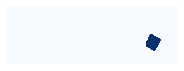

In [16]:
image = Image.open("scenarios2.png").convert('RGB')
# keep a copy of the original image for OpenCV functions and applying masks
orig_image = image.copy()
# transform the image
print(image.size)
image = transform(image)
print(image.shape)
# add a batch dimension
image = image.unsqueeze(0).to(device)
print(image.shape)
masks, boxes, labels = get_outputs(image, model, 0.85)
result = draw_segmentation_map(orig_image, masks, boxes, labels)
# visualize the image
cv2.imshow('Segmented image', result)
#cv2.waitKey(100)



In [15]:
def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interpolation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()

In [11]:
def segmentImage(image, label):
    # initialize the model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, progress=True, 
                                                            num_classes=91)
    # set the computation device
    device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
    # load the modle on to the computation device and set to eval mode
    model.to(device).eval()

    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    orig_image = image.copy()
    # transform the image
    image = transform(image)
    # add a batch dimension
    #print(image.unsqueeze(0).shape)
    image = image.unsqueeze(0).to(device)
    #print(image)
    masks, boxes, labels = get_outputs(image, model, 0.85)
    result = draw_segmentation_map(orig_image, masks, boxes, labels)
    cv2.imwrite("maskrcnnOutput.png", result)
    cv2.imshow('Segmented image', result)

    # shorten the list of labels to the number of boxes we have
    numLabels = len(boxes)
    labels = labels[:numLabels]
    

    try:
        boxNumber = labels.index(label)
    except:
        return 0

    return boxes[boxNumber] 

image = Image.open("scenarios2.png").convert('RGB')
label = "scissors"
box= segmentImage(image, label)
print(box)

[(371, 177), (497, 249)]


In [18]:
top_bound, left_bound, = box[0]
bottom_bound, right_bound = box[1]

: 

In [17]:
left

177

In [ ]:

def qImgSegmenter(orig_image, box):
    #data_address = orig_image.load()
    for y in range(orig_image.size[1]):
        for x in range(orig_image.size[0]):
            if (x < box[0][0] or x > box[1][0]) or (y < box[0][1] or y > box[1][1]):
                data_address[x, y] = (0,0,0)
        return data_address

#data_address = qImgSegmenter(orig_image, box)

In [ ]:
import numpy as np

qimg = np.random.rand(10,10)
box  =[(371, 177), (497, 249)]

data_address = qImgSegmenter(qimg, box)


AttributeError: 'numpy.ndarray' object has no attribute 'load'

In [ ]:
sciBox = boxes[1]
sciBox
res = [list(ele) for ele in sciBox]
res

[[371, 177], [497, 249]]

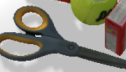

In [ ]:
area = (371, 177, 497, 249)
cropped_img = orig_image.crop(area)
cropped_img

In [75]:
image = Image.open("scenarios2.png")

asArray = np.asarray(image)
asArray.shape
#newimag = asArray[1, :, :371, :177] = (255,255,255)

(305, 903, 3)

(903, 3, 305)

In [77]:
trans = np.transpose(newIm, (1,2,0))

(903, 3, 305)

In [66]:
red = asArray[:,:,0]
green = asArray[:,:,1]
blue = asArray[:,:,2]

newIm = np.array([red, green, blue])/255
newIm.shape

(3, 305, 903)

In [81]:
trans = np.transpose(newIm, (1,2,0))
trans.shape

(305, 903, 3)

In [68]:
newIm.shape[1]

305

In [65]:
def segmentImage(image, label):
    # initialize the model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, progress=True, 
                                                            num_classes=91)
    # set the computation device
    device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
    # load the modle on to the computation device and set to eval mode
    model.to(device).eval()
    height = image.shape[1]
    width  = image.shape[2]

    orig_image = image.copy()
    # add a batch dimension
    image = torch.from_numpy(image.reshape(1, 3, height, width))
    image = image.to(device)
    masks, boxes, labels = get_outputs(image, model, 0.85)
    result = draw_segmentation_map(orig_image, masks, boxes, labels)
    cv2.imwrite("maskrcnnOutput.png", result)
    cv2.imshow('Segmented image', result)

    # shorten the list of labels to the number of boxes we have
    numLabels = len(boxes)
    labels = labels[:numLabels]
    

    try:
        boxNumber = labels.index(label)
    except:
        return 0

    return boxes[boxNumber] 
    
label = "scissors"
box = segmentImage(newIm, label)
print(box)

RuntimeError: expected scalar type Double but found Float

In [ ]:
labels

['sports ball',
 'scissors',
 'banana',
 'traffic light',
 'banana',
 'book',
 'kite',
 'banana',
 'banana',
 'bottle',
 'cup',
 'traffic light',
 'hair drier',
 'fire hydrant',
 'hair drier',
 'handbag',
 'dining table',
 'fire hydrant',
 'skateboard']

In [ ]:
masks.shape

(3, 305, 903)

In [ ]:
boxes

[[(441, 156), (487, 202)], [(371, 177), (497, 249)], [(709, 77), (816, 138)]]